In [1]:
import pandas as pd
df = pd.read_excel('Dataset (2).xlsx')


In [2]:
# Filter out 'unknown' race instances
df = df[~df['Race'].isin(['Unknown'])]
del df['Gender']
print(df)

                     Age       Race  CatsInHouse  \
0       Less than 1 year     Birman            3   
1       Less than 1 year     Birman            1   
2             2-10 years   European            4   
3       Less than 1 year   European            1   
4              1-2 years     Birman            2   
...                  ...        ...          ...   
3138          2-10 years    Persian            1   
3139    Less than 1 year  MaineCoon            3   
3140  More than 10 years      Other            1   
3141    Less than 1 year     Bengal            1   
3142    Less than 1 year     Bengal            5   

                            HousingType       Zone  TimeOutside  \
0             Apartment without balcony      Urban            0   
1     Apartment with balcony or terrace      Urban            0   
2                House in a subdivision      Urban            0   
3                House in a subdivision      Rural            2   
4                 Individual house zone 

In [3]:
# Calculate the mean of numeric values
numeric_mask = df['NaturalAreasAbundance'] != 'Unknown'
mean_value = pd.to_numeric(df[numeric_mask]['NaturalAreasAbundance']).mean()

# Replace 'Unknown' with the mean value and round to nearest integer
df['NaturalAreasAbundance'] = df['NaturalAreasAbundance'].replace('Unknown', mean_value)
df['NaturalAreasAbundance'] = df['NaturalAreasAbundance'].astype(float).round().astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3063 entries, 0 to 3142
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    3063 non-null   object
 1   Race                   3063 non-null   object
 2   CatsInHouse            3063 non-null   int64 
 3   HousingType            3063 non-null   object
 4   Zone                   3063 non-null   object
 5   TimeOutside            3063 non-null   int64 
 6   TimeWithOwner          3063 non-null   int64 
 7   Shy                    3063 non-null   int64 
 8   Calm                   3063 non-null   int64 
 9   Skittish               3063 non-null   int64 
 10  Intelligent            3063 non-null   int64 
 11  Vigilant               3063 non-null   int64 
 12  Tenacious              3063 non-null   int64 
 13  Affectionate           3063 non-null   int64 
 14  Friendly               3063 non-null   int64 
 15  Loner                  306

In [4]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

def balance_dataset_custom(df, race_counts_dict):
    """
    Balance the dataset according to custom counts for each race.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    race_counts_dict (dict): Dictionary with races as keys and desired counts as values
                            Example: {'European': 500, 'Sphynx': 100, ...}
    
    Returns:
    pandas.DataFrame: Balanced dataset with specified counts for each race
    """
    # Create an empty DataFrame to store the balanced data
    balanced_df = pd.DataFrame()
    
    # Get all race columns
    race_columns = [col for col in df.columns if col.startswith('Race_')]
    
    # Process each race
    for race in race_counts_dict.keys():
        race_col = f'Race_{race}'
        
        # Skip if race column doesn't exist
        if race_col not in df.columns:
            print(f"Warning: {race} not found in dataset. Skipping...")
            continue
            
        # Get samples for current race
        race_samples = df[df[race_col] == True]
        desired_count = race_counts_dict[race]
        current_count = len(race_samples)
        
        if desired_count == current_count:
            # If we want the same number of samples, just add them
            balanced_df = pd.concat([balanced_df, race_samples])
        
        elif desired_count < current_count:
            # If we want fewer samples, randomly select without replacement
            sampled = race_samples.sample(n=desired_count, random_state=42)
            balanced_df = pd.concat([balanced_df, sampled])
            
        else:
            # If we want more samples, use oversampling
            resampled = resample(race_samples,
                               replace=True,
                               n_samples=desired_count,
                               random_state=42)
            balanced_df = pd.concat([balanced_df, resampled])
    
    # Reset index
    balanced_df = balanced_df.reset_index(drop=True)
    
    # Print summary of new race distribution
    print("\nNew race distribution:")
    for race in race_counts_dict.keys():
        race_col = f'Race_{race}'
        if race_col in balanced_df.columns:
            count = sum(balanced_df[race_col])
            print(f"{race}: {count}")
            
    return balanced_df

# Example usage:
# Define your desired counts for each race
desired_counts = {
    'European': 800,
    'NoBreed': 600,
    'Bengal': 500,
    'Ragdoll': 400,
    'MaineCoon': 350,
    'Birman': 300,
    'Persian': 300,
    'BritishShorthair': 300,
    'Other': 300,
    'Sphynx': 200,
    'Siamese': 130,
    'Chartreux': 100,
    'TurkishAngora': 100,
    'Savannah': 100
}

# Balance the dataset
df = balance_dataset_custom(df, desired_counts)


New race distribution:


In [5]:
import pandas as pd

def add_breed_specific_traits(df):
    """
    Add breed-specific traits to the cat dataset:
    - FlatFace: True for Persian cats
    - LimpWhenHeld: True for Ragdoll cats
    - Hairless: True for Sphynx cats
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with Race_ columns
    
    Returns:
    pandas.DataFrame: DataFrame with new trait columns added
    """
    # Create a copy to avoid modifying the original DataFrame
    df_new = df.copy()
    
    # Add FlatFace attribute (True for Persian cats)
    df_new['FlatFace'] = df_new['Race_Persian']
    
    # Add LimpWhenHeld attribute (True for Ragdoll cats)
    df_new['LimpWhenHeld'] = df_new['Race_Ragdoll']
    
    # Add Hairless attribute (True for Sphynx cats)
    df_new['Hairless'] = df_new['Race_Sphynx']
    
    return df_new

# Assuming your DataFrame is called 'df'
df = add_breed_specific_traits(df)

KeyError: 'Race_Persian'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def create_single_race_column(df):
    """
    Convert one-hot encoded race columns into a single categorical column.
    Returns the race column and the original dataframe.
    """
    # Get all race column names
    race_columns = [col for col in df.columns if col.startswith('Race_')]
    
    # Create a single race column
    race_series = pd.Series('Unknown', index=df.index)
    for col in race_columns:
        # For each True value, set the race name (removing 'Race_' prefix)
        race_series[df[col]] = col.replace('Race_', '')
    
    return race_series

def split_cat_dataset(df, test_size=0.1, random_state=42):
    """
    Perform stratified split on the cat dataset based on races.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing cat data
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    train_df, test_df : tuple of pandas.DataFrame
        The split datasets
    """
    # Create single race column for stratification
    race_column = create_single_race_column(df)
    
    # Perform stratified split
    train_idx, test_idx = train_test_split(
        np.arange(len(df)),
        test_size=test_size,
        random_state=random_state,
        stratify=race_column
    )
    
    # Split the dataframe
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()
    
    # Print split information
    print(f"Training set size: {len(train_df)} ({(1-test_size)*100:.1f}%)")
    print(f"Test set size: {len(test_df)} ({test_size*100:.1f}%)")
    
    # Verify stratification
    print("\nRace distribution in original dataset:")
    original_dist = race_column.value_counts(normalize=True)
    print(original_dist)
    
    print("\nRace distribution in training set:")
    train_dist = create_single_race_column(train_df).value_counts(normalize=True)
    print(train_dist)
    
    print("\nRace distribution in test set:")
    test_dist = create_single_race_column(test_df).value_counts(normalize=True)
    print(test_dist)
    
    return train_df, test_df

# Split the dataset
df, test_df = split_cat_dataset(df, test_size=0.1, random_state=42)

Training set size: 3628 (90.0%)
Test set size: 404 (10.0%)

Race distribution in original dataset:
European            0.178571
NoBreed             0.133929
Bengal              0.111607
Ragdoll             0.089286
MaineCoon           0.078125
Other               0.066964
Persian             0.066964
BritishShorthair    0.066964
Birman              0.066964
Sphynx              0.044643
Siamese             0.029018
TurkishAngora       0.022321
Savannah            0.022321
Chartreux           0.022321
Name: proportion, dtype: float64

Race distribution in training set:
European            0.178611
NoBreed             0.133958
Bengal              0.111632
Ragdoll             0.089305
MaineCoon           0.078004
BritishShorthair    0.066979
Birman              0.066979
Other               0.066979
Persian             0.066979
Sphynx              0.044653
Siamese             0.028942
Chartreux           0.022326
Savannah            0.022326
TurkishAngora       0.022326
Name: proportion, dt

In [ ]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 4032 entries, 2115 to 4138
Data columns (total 43 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Age                                            4032 non-null   float64
 1   CatsInHouse                                    4032 non-null   int64  
 2   TimeOutside                                    4032 non-null   int64  
 3   TimeWithOwner                                  4032 non-null   int64  
 4   Shy                                            4032 non-null   int64  
 5   Calm                                           4032 non-null   int64  
 6   Skittish                                       4032 non-null   int64  
 7   Intelligent                                    4032 non-null   int64  
 8   Vigilant                                       4032 non-null   int64  
 9   Tenacious                                      4032 no

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define a distinct color palette for cat breeds
DISTINCT_COLORS = {
    'Bengal': '#FF0000',         # Red
    'Birman': '#00FF00',         # Green
    'BritishShorthair': '#0000FF', # Blue
    'Chartreux': '#FFA500',      # Orange
    'European': '#800080',       # Purple
    'MaineCoon': '#FFD700',      # Gold
    'NoBreed': '#4B0082',        # Indigo
    'Other': '#808080',          # Gray
    'Persian': '#FF1493',        # Deep Pink
    'Ragdoll': '#00FFFF',        # Cyan
    'Savannah': '#FF4500',       # Orange Red
    'Siamese': '#9400D3',        # Violet
    'Sphynx': '#32CD32',         # Lime Green
    'TurkishAngora': '#FF8C00'   # Dark Orange
}

# Function to prepare the data
def prepare_data(df):
    # Separate features and target
    # Exclude all Race_ columns as they are our target
    feature_cols = [col for col in df.columns if not col.startswith('Race_')]
    X = df[feature_cols]

    # Create target column (single label for each cat)
    race_cols = [col for col in df.columns if col.startswith('Race_')]
    y = df[race_cols].idxmax(axis=1).str.replace('Race_', '')

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Function to create PCA visualization
def create_pca_plots(X_scaled, y):
    # 2D PCA
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    # 3D PCA
    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(X_scaled)

    # Calculate explained variance ratios
    var_ratio_2d = pca_2d.explained_variance_ratio_
    var_ratio_3d = pca_3d.explained_variance_ratio_

    # Create subplot with 2D and 3D PCA
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'xy'}, {'type': 'scene'}]],
        subplot_titles=(
            f'2D PCA (Variance explained: {var_ratio_2d[0]:.1%}, {var_ratio_2d[1]:.1%})',
            f'3D PCA (Variance explained: {var_ratio_3d[0]:.1%}, {var_ratio_3d[1]:.1%}, {var_ratio_3d[2]:.1%})'
        )
    )

    # Create color array
    colors = [DISTINCT_COLORS[breed] for breed in y]

    # 2D PCA plot
    for breed in DISTINCT_COLORS.keys():
        mask = y == breed
        if np.any(mask):
            fig.add_trace(
                go.Scatter(
                    x=X_pca_2d[mask, 0],
                    y=X_pca_2d[mask, 1],
                    mode='markers',
                    marker=dict(size=8, color=DISTINCT_COLORS[breed]),
                    name=breed,
                    text=y[mask],
                    showlegend=True
                ),
                row=1, col=1
            )

    # 3D PCA plot
    for breed in DISTINCT_COLORS.keys():
        mask = y == breed
        if np.any(mask):
            fig.add_trace(
                go.Scatter3d(
                    x=X_pca_3d[mask, 0],
                    y=X_pca_3d[mask, 1],
                    z=X_pca_3d[mask, 2],
                    mode='markers',
                    marker=dict(size=4, color=DISTINCT_COLORS[breed]),
                    name=breed,
                    text=y[mask],
                    showlegend=False
                ),
                row=1, col=2
            )

    # Update layout
    fig.update_layout(
        title='PCA Visualization of Cat Breeds',
        height=700,
        width=1400,
        legend=dict(
            itemsizing='constant',
            title=dict(text='Cat Breeds'),
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        template='plotly_white'
    )

    return fig

# Function to create t-SNE visualization
def create_tsne_plots(X_scaled, y):
    # 2D t-SNE
    tsne_2d = TSNE(n_components=2, random_state=42)
    X_tsne_2d = tsne_2d.fit_transform(X_scaled)

    # 3D t-SNE
    tsne_3d = TSNE(n_components=3, random_state=42)
    X_tsne_3d = tsne_3d.fit_transform(X_scaled)

    # Create subplot with 2D and 3D t-SNE
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'xy'}, {'type': 'scene'}]],
        subplot_titles=('2D t-SNE', '3D t-SNE')
    )

    # 2D t-SNE plot
    for breed in DISTINCT_COLORS.keys():
        mask = y == breed
        if np.any(mask):
            fig.add_trace(
                go.Scatter(
                    x=X_tsne_2d[mask, 0],
                    y=X_tsne_2d[mask, 1],
                    mode='markers',
                    marker=dict(size=8, color=DISTINCT_COLORS[breed]),
                    name=breed,
                    text=y[mask],
                    showlegend=True
                ),
                row=1, col=1
            )

    # 3D t-SNE plot
    for breed in DISTINCT_COLORS.keys():
        mask = y == breed
        if np.any(mask):
            fig.add_trace(
                go.Scatter3d(
                    x=X_tsne_3d[mask, 0],
                    y=X_tsne_3d[mask, 1],
                    z=X_tsne_3d[mask, 2],
                    mode='markers',
                    marker=dict(size=4, color=DISTINCT_COLORS[breed]),
                    name=breed,
                    text=y[mask],
                    showlegend=False
                ),
                row=1, col=2
            )

    # Update layout
    fig.update_layout(
        title='t-SNE Visualization of Cat Breeds',
        height=700,
        width=1400,
        legend=dict(
            itemsizing='constant',
            title=dict(text='Cat Breeds'),
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        template='plotly_white'
    )

    return fig

# Main execution
def visualize_cat_data(df):
    # Prepare the data
    X_scaled, y = prepare_data(df)

    # Create PCA plots
    pca_fig = create_pca_plots(X_scaled, y)

    # Create t-SNE plots
    tsne_fig = create_tsne_plots(X_scaled, y)

    return pca_fig, tsne_fig

# Example usage:
pca_fig, tsne_fig = visualize_cat_data(df)
pca_fig.show()
tsne_fig.show()

Age        CatsInHouse  TimeOutside  TimeWithOwner  Shy  Calm  Skittish  Intelligent  Vigilant  Tenacious  Affectionate  Friendly  Loner  Ferocious  Territorial  Aggressive  Impulsive  Predictable  Inattentive  NaturalAreasAbundance  BirdsEater  MiceEater  HousingType_Apartment with balcony or terrace  HousingType_Apartment without balcony  HousingType_House in a subdivision  HousingType_Individual house zone  Zone_Periurban  Zone_Rural  Zone_Urban  Race_Bengal  Race_Birman  Race_BritishShorthair  Race_Chartreux  Race_European  Race_MaineCoon  Race_NoBreed  Race_Other  Race_Persian  Race_Ragdoll  Race_Savannah  Race_Siamese  Race_Sphynx  Race_TurkishAngora  FlatFace  LimpWhenHeld  Hairless
0.500000   2            1            3              4    3     1         4            4         4          2             3         3      1          3            1           4          4            3            2                      0           0          True                                        

C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/250
114/114 - 3s - 26ms/step - accuracy: 0.2511 - loss: 3.1513 - val_accuracy: 0.3812 - val_loss: 2.6742
Epoch 2/250
114/114 - 0s - 3ms/step - accuracy: 0.4057 - loss: 2.4589 - val_accuracy: 0.4208 - val_loss: 2.2749
Epoch 3/250
114/114 - 0s - 2ms/step - accuracy: 0.4236 - loss: 2.1942 - val_accuracy: 0.4381 - val_loss: 2.1269
Epoch 4/250
114/114 - 0s - 2ms/step - accuracy: 0.4460 - loss: 2.0396 - val_accuracy: 0.4455 - val_loss: 2.0035
Epoch 5/250
114/114 - 0s - 2ms/step - accuracy: 0.4639 - loss: 1.9474 - val_accuracy: 0.4703 - val_loss: 1.9262
Epoch 6/250
114/114 - 0s - 2ms/step - accuracy: 0.4678 - loss: 1.8738 - val_accuracy: 0.4703 - val_loss: 1.8536
Epoch 7/250
114/114 - 0s - 3ms/step - accuracy: 0.4826 - loss: 1.8147 - val_accuracy: 0.4827 - val_loss: 1.8093
Epoch 8/250
114/114 - 0s - 3ms/step - accuracy: 0.4854 - loss: 1.7545 - val_accuracy: 0.4604 - val_loss: 1.7743
Epoch 9/250
114/114 - 0s - 2ms/step - accuracy: 0.4846 - loss: 1.7285 - val_accuracy: 0.4901 - val_loss

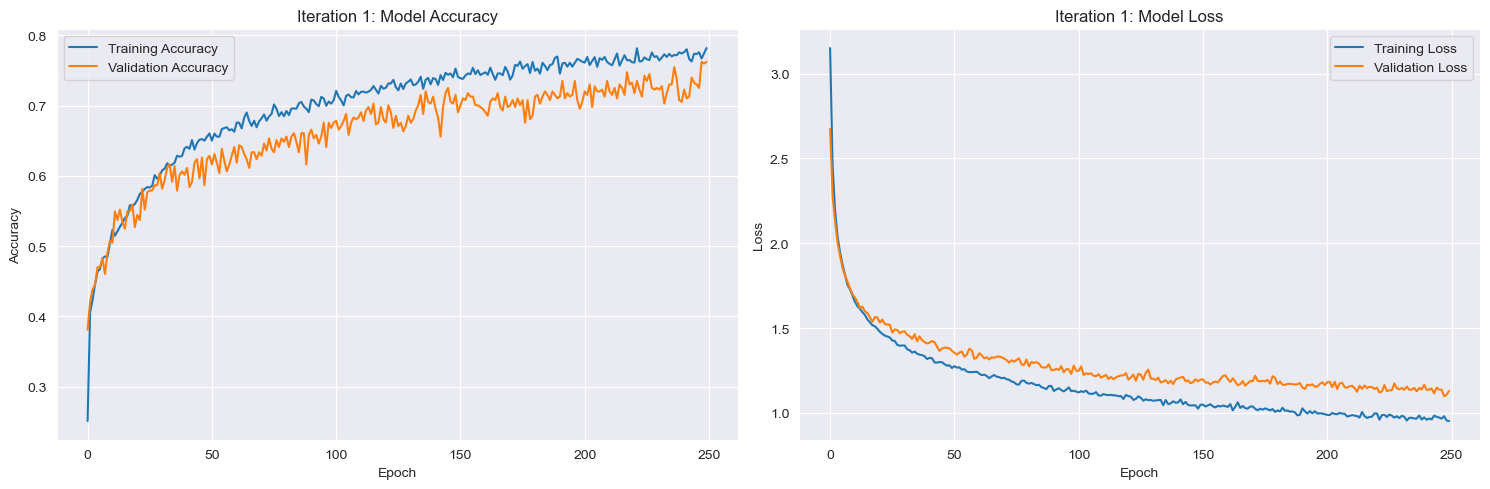


Final metrics for iteration 1:
Training Accuracy: 0.7820
Validation Accuracy: 0.7624
Training Loss: 0.9513
Validation Loss: 1.1291
Best Validation Accuracy: 0.7624

Iteration 2/3
Epoch 1/250


C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



114/114 - 3s - 23ms/step - accuracy: 0.2811 - loss: 3.0867 - val_accuracy: 0.4134 - val_loss: 2.4956
Epoch 2/250
114/114 - 0s - 2ms/step - accuracy: 0.4068 - loss: 2.4210 - val_accuracy: 0.4554 - val_loss: 2.2156
Epoch 3/250
114/114 - 0s - 3ms/step - accuracy: 0.4319 - loss: 2.1957 - val_accuracy: 0.4752 - val_loss: 2.0445
Epoch 4/250
114/114 - 0s - 2ms/step - accuracy: 0.4435 - loss: 2.0520 - val_accuracy: 0.4876 - val_loss: 1.9406
Epoch 5/250
114/114 - 0s - 2ms/step - accuracy: 0.4540 - loss: 1.9528 - val_accuracy: 0.4827 - val_loss: 1.8398
Epoch 6/250
114/114 - 0s - 2ms/step - accuracy: 0.4678 - loss: 1.8731 - val_accuracy: 0.4950 - val_loss: 1.7864
Epoch 7/250
114/114 - 0s - 2ms/step - accuracy: 0.4689 - loss: 1.8076 - val_accuracy: 0.5000 - val_loss: 1.7332
Epoch 8/250
114/114 - 0s - 2ms/step - accuracy: 0.4920 - loss: 1.7495 - val_accuracy: 0.5173 - val_loss: 1.7153
Epoch 9/250
114/114 - 0s - 2ms/step - accuracy: 0.4972 - loss: 1.7161 - val_accuracy: 0.5520 - val_loss: 1.6442
Epo

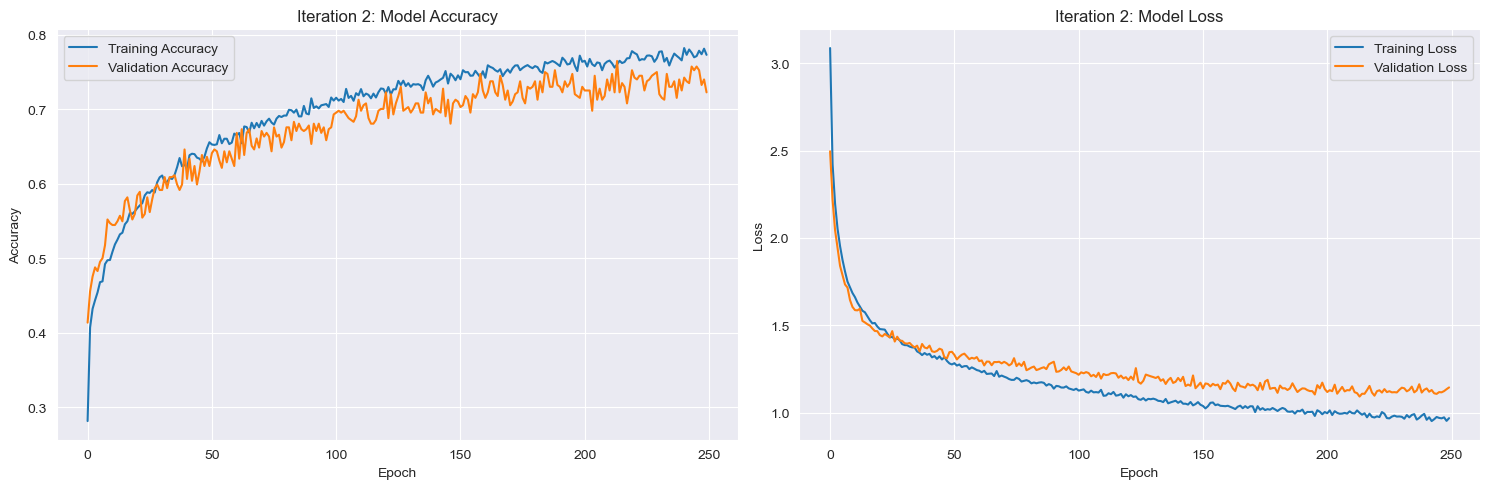


Final metrics for iteration 2:
Training Accuracy: 0.7732
Validation Accuracy: 0.7228
Training Loss: 0.9677
Validation Loss: 1.1435
Best Validation Accuracy: 0.7649

Iteration 3/3
Epoch 1/250


C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



114/114 - 2s - 22ms/step - accuracy: 0.2602 - loss: 3.1240 - val_accuracy: 0.3985 - val_loss: 2.5440
Epoch 2/250
114/114 - 0s - 2ms/step - accuracy: 0.4146 - loss: 2.4045 - val_accuracy: 0.4307 - val_loss: 2.2313
Epoch 3/250
114/114 - 0s - 2ms/step - accuracy: 0.4399 - loss: 2.1556 - val_accuracy: 0.4282 - val_loss: 2.0884
Epoch 4/250
114/114 - 0s - 2ms/step - accuracy: 0.4515 - loss: 2.0266 - val_accuracy: 0.4307 - val_loss: 1.9780
Epoch 5/250
114/114 - 0s - 3ms/step - accuracy: 0.4644 - loss: 1.9269 - val_accuracy: 0.4505 - val_loss: 1.8974
Epoch 6/250
114/114 - 0s - 2ms/step - accuracy: 0.4713 - loss: 1.8536 - val_accuracy: 0.4233 - val_loss: 1.8440
Epoch 7/250
114/114 - 0s - 2ms/step - accuracy: 0.4793 - loss: 1.7997 - val_accuracy: 0.4604 - val_loss: 1.7909
Epoch 8/250
114/114 - 0s - 2ms/step - accuracy: 0.4917 - loss: 1.7520 - val_accuracy: 0.4876 - val_loss: 1.7527
Epoch 9/250
114/114 - 0s - 3ms/step - accuracy: 0.5058 - loss: 1.6981 - val_accuracy: 0.4752 - val_loss: 1.7312
Epo

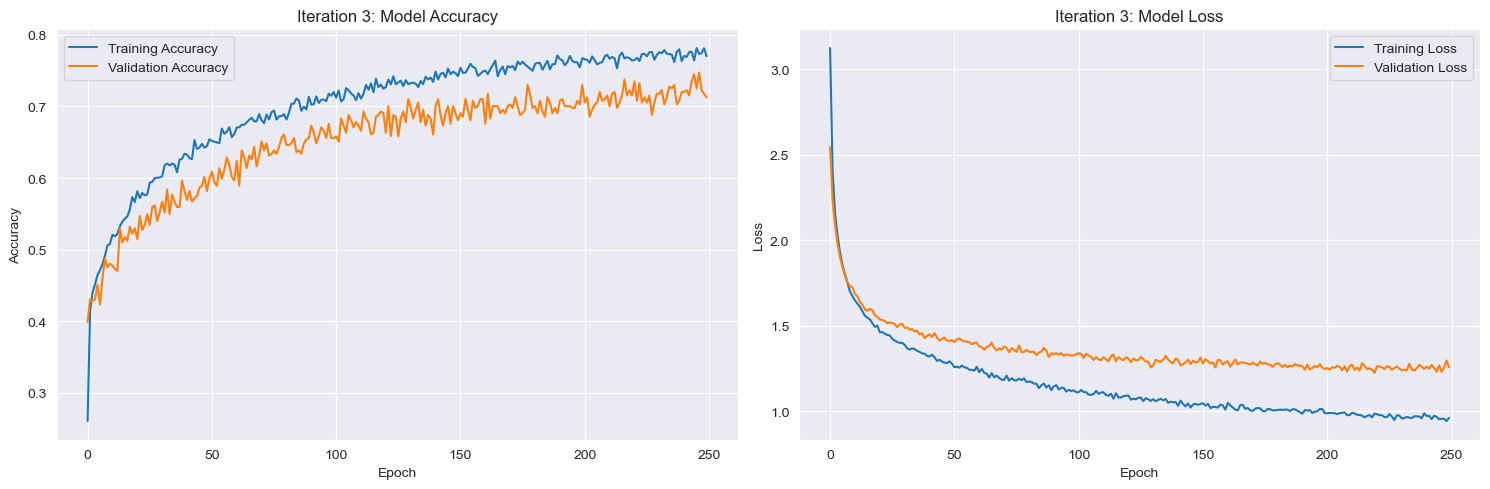


Final metrics for iteration 3:
Training Accuracy: 0.7704
Validation Accuracy: 0.7129
Training Loss: 0.9607
Validation Loss: 1.2553
Best Validation Accuracy: 0.7475

Overall training results:
Mean validation accuracy: 0.7583
Standard deviation: 0.0077


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create the model with L2 regularization
def create_model(input_dim, output_dim, l2_lambda=0.005):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda), input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dense(output_dim, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_training_history(history, iteration):
    """Plot training & validation accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'Iteration {iteration + 1}: Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'Iteration {iteration + 1}: Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal metrics for iteration {iteration + 1}:")
    print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

def train_and_evaluate_model(X, y, n_iterations=3):
    # Convert the target variables to numerical format
    race_columns = [col for col in y.columns if col.startswith('Race_')]
    y_encoded = y[race_columns].values
    
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Initialize lists to store results
    val_accuracies = []
    best_model = None
    best_val_accuracy = 0
    
    # Perform multiple training iterations
    for iteration in range(n_iterations):
        print(f"\nIteration {iteration + 1}/{n_iterations}")
        
        # Split data - 90% training, 10% validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_encoded, 
            test_size=0.1, 
            random_state=42 + iteration  # Different random state for each iteration
        )
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Create and train model
        model = create_model(X_train.shape[1], y_encoded.shape[1])
        
        history = model.fit(
            X_train_scaled, y_train,
            epochs=250,
            batch_size=32,
            validation_data=(X_val_scaled, y_val),
            verbose=2
        )
        
        # Plot training history
        plot_training_history(history, iteration)
        
        # Evaluate model
        val_accuracy = max(history.history['val_accuracy'])
        val_accuracies.append(val_accuracy)
        
        print(f"Best Validation Accuracy: {val_accuracy:.4f}")
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = tf.keras.models.clone_model(model)
            best_model.set_weights(model.get_weights())
    
    print("\nOverall training results:")
    print(f"Mean validation accuracy: {np.mean(val_accuracies):.4f}")
    print(f"Standard deviation: {np.std(val_accuracies):.4f}")
    
    return best_model, val_accuracies

# Prepare the data
def prepare_data(data):
    # Separate features and target
    race_columns = [col for col in data.columns if col.startswith('Race_')]
    X = data.drop(columns=race_columns)
    y = data[race_columns]
    
    return X, y

# Main execution
def main(data):
    # Prepare data
    X, y = prepare_data(data)
    
    # Train and evaluate model
    best_model, accuracies = train_and_evaluate_model(X, y)
    
    return best_model, accuracies

# Example usage
print(df.value_counts())
print(df.info())
    
best_model, accuracies = main(df)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Model Evaluation on Test Data ===

Overall Test Accuracy: 0.8663

Classification Report:
                  precision    recall  f1-score   support

          Bengal       0.82      0.93      0.88        45
          Birman       0.73      0.81      0.77        27
BritishShorthair       0.82      1.00      0.90        27
       Chartreux       1.00      0.78      0.88         9
        European       0.76      0.62      0.69        72
       MaineCoon       0.84      0.97      0.90        32
         NoBreed       0.89      0.87      0.88        54
           Other       0.89      0.89      0.89        27
         Persian       1.00      1.00      1.00        27
         Ragdoll       1.00      1.00      1.00        36
        Savannah       0.89      0.89      0.89         9
         Siamese       0.91      0.83      0.87        12
          Sphynx       1.00      1.00      1.00        18
   TurkishAngora       1.00      0.67      0.80       

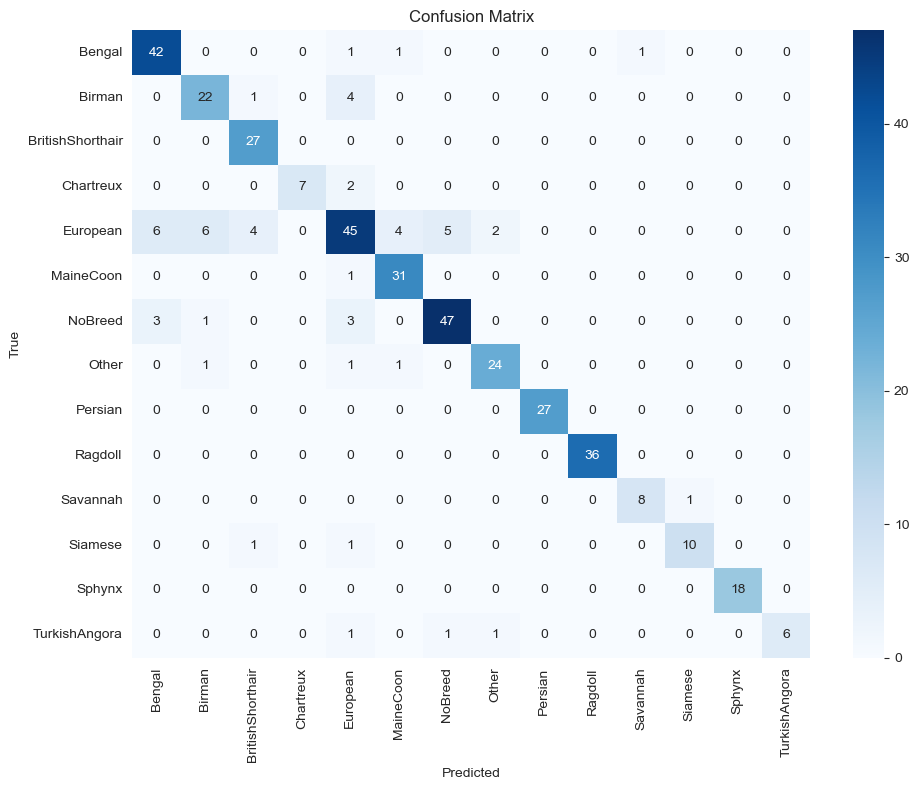

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(best_model, test_df):
    """
    Test the trained model on a new test dataset.
    
    Parameters:
    best_model: trained Keras model
    test_df: pandas DataFrame containing test data
    
    Returns:
    dict containing test accuracy, predictions, and evaluation metrics
    """
    # Prepare test data
    race_columns = [col for col in test_df.columns if col.startswith('Race_')]
    X_test = test_df.drop(columns=race_columns)
    y_test = test_df[race_columns]
    
    # Scale features using the same approach as training
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Make predictions
    y_pred_proba = best_model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test.values, axis=1)
    
    # Calculate accuracy
    test_accuracy = np.mean(y_pred == y_test_classes)
    
    # Generate classification report
    class_names = [col.replace('Race_', '') for col in race_columns]
    report = classification_report(y_test_classes, y_pred, target_names=class_names)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    # Calculate per-class metrics
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        true_class = (y_test_classes == i)
        pred_class = (y_pred == i)
        
        true_positives = np.sum(true_class & pred_class)
        false_positives = np.sum(~true_class & pred_class)
        false_negatives = np.sum(true_class & ~pred_class)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        per_class_metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return {
        'test_accuracy': test_accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'per_class_metrics': per_class_metrics,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba
    }

# Example usage
def evaluate_test_results(test_df, best_model):
    """
    Evaluate and print test results in a readable format.
    """
    results = test_model(best_model, test_df)
    
    print("\n=== Model Evaluation on Test Data ===")
    print(f"\nOverall Test Accuracy: {results['test_accuracy']:.4f}")
    
    print("\nClassification Report:")
    print(results['classification_report'])
    
    print("\nPer-Class Metrics:")
    for class_name, metrics in results['per_class_metrics'].items():
        print(f"\n{class_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    return results

# To use the testing script:
results = evaluate_test_results(test_df, best_model)